<a href="https://colab.research.google.com/github/douglasmasho/MedAlgo/blob/main/TumorGrade2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import zipfile
import os

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install monai

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
import os
import glob
from sklearn.model_selection import train_test_split

extract_dir = '/content/drive/MyDrive/BRATS'

def find_nifti_files(root_dir, label):
    """Recursively find all .nii files in subdirectories and assign a label."""
    file_paths = []
    for subdir, _, _ in os.walk(root_dir):
        file_paths.extend(glob.glob(os.path.join(subdir, '*.nii')))
    return file_paths, [label] * len(file_paths)

# Define paths
hgg_path = os.path.join(extract_dir, "MICCAI_BraTS_2019_Data_Training",'HGG')
lgg_path = os.path.join(extract_dir, "MICCAI_BraTS_2019_Data_Training",'LGG')

# Find all .nii files
hgg_files, hgg_labels = find_nifti_files(hgg_path, 1)  # High-grade glioma
lgg_files, lgg_labels = find_nifti_files(lgg_path, 0)  # Low-grade glioma

print(f'HGG files: {len(hgg_files)}')
print(f'LGG files: {len(lgg_files)}')

# Combine and split data
all_files = hgg_files + lgg_files
all_labels = hgg_labels + lgg_labels

print(f'All files: {len(all_files)}')
print(f'All labels: {len(all_labels)}')

# Ensure non-empty lists before splitting
if len(all_files) == 0 or len(all_labels) == 0:
    raise ValueError("The file paths or labels are empty. Check the directory and file extensions.")

train_files, val_files, train_labels, val_labels = train_test_split(
    all_files, all_labels, test_size=0.2, stratify=all_labels, random_state=42
)

In [ ]:
import monai
from monai.transforms import Compose, LoadImage, ScaleIntensity, EnsureChannelFirst, Resize, ToTensor
from monai.data import Dataset, DataLoader

# Define transformations
transforms = Compose([
    LoadImage(image_only=True),  # Load NIfTI image
    ScaleIntensity(),            # Normalize intensity
    EnsureChannelFirst(),        # Add channel dimension
    Resize((128, 128, 128)),     # Resize to a fixed size
    ToTensor()                   # Convert to tensor
])

# Create custom dataset class
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = image_path  # Load image directly
        if self.transform:
            image = self.transform(image)
        return {'image': image, 'label': label}

# Create datasets and dataloaders
train_dataset = CustomDataset(train_files, train_labels, transform=transforms)
val_dataset = CustomDataset(val_files, val_labels, transform=transforms)

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)


In [ ]:
!pip install monai


In [ ]:
import os
import nibabel as nib
import numpy as np
from PIL import Image
import torch
import monai
from monai.transforms import (
    Compose, LoadImage, EnsureChannelFirst, ScaleIntensity,
    Resize, ToTensor, RandAffine, RandRotate90
)
from monai.data import DataLoader, ImageDataset
from monai.networks.nets import DenseNet121
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter
from monai.losses import DiceLoss

# Step 1: Slice .nii Files into .jpg Images (only t1ce sequences)

# Define paths
input_dir = '/content/drive/MyDrive/BRATS'  # Directory with nii files
output_dir = '/content/drive/MyDrive/BRATS_JPG'  # Output directory for jpg images

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Iterate over all .nii files in the input directory
for root, dirs, files in os.walk(input_dir):
    for file in files:
        if ('t1ce' in file) and (file.endswith('.nii') or file.endswith('.nii.gz')):
            file_path = os.path.join(root, file)
            nii_data = nib.load(file_path)
            images = nii_data.get_fdata()

            # Determine the class from the directory name
            if 'HGG' in root:
                label = 'HGG'
            elif 'LGG' in root:
                label = 'LGG'
            else:
                continue  # Skip if the directory is not labeled as HGG or LGG

            # Create class-specific output directory under BRATS_JPG
            class_output_dir = os.path.join(output_dir, label)
            os.makedirs(class_output_dir, exist_ok=True)

            # Normalize and convert each slice to an image
            for i in range(images.shape[2]):  # Assuming we're slicing along the third axis
                slice_data = images[:, :, i]
                slice_data = (slice_data - slice_data.min()) / (slice_data.max() - slice_data.min())  # Normalize to [0, 1]
                slice_data = (255 * slice_data).astype(np.uint8)  # Scale to [0, 255]

                # Convert to PIL Image and save as .jpg in the appropriate class directory
                img = Image.fromarray(slice_data)
                img.save(os.path.join(class_output_dir, f"{file}_{i}.jpg"))

print("Slicing complete!")

# Step 2: Use .jpg Images for Training

# Define paths to .jpg data
data_dir = '/content/drive/MyDrive/BRATS_JPG'

# Prepare image files and corresponding labels
image_files = []
labels = []
for label_dir in ['HGG', 'LGG']:
    label_path = os.path.join(data_dir, label_dir)
    label = 0 if label_dir == 'HGG' else 1  # HGG = 0, LGG = 1
    for fname in os.listdir(label_path):
        if fname.endswith('.jpg'):
            image_files.append(os.path.join(label_path, fname))
            labels.append(label)

# Define transformations
train_transforms = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    ScaleIntensity(),
    Resize(spatial_size=(128, 128)),
    RandAffine(prob=0.5, rotate_range=(0.1, 0.1)),
    RandRotate90(prob=0.5),
    ToTensor()
])

val_transforms = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    ScaleIntensity(),
    Resize(spatial_size=(128, 128)),
    ToTensor()
])

# Prepare the dataset
train_ds = ImageDataset(image_files, labels, transform=train_transforms)
val_ds = ImageDataset(image_files, labels, transform=val_transforms)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False)

# Define the model, loss, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DenseNet121(spatial_dims=2, in_channels=1, out_channels=2).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = Adam(model.parameters(), lr=1e-4)

# Training loop and validation loop
num_epochs = 50
best_acc = 0.0
writer = SummaryWriter()

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    for batch_data in train_loader:
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += (outputs.argmax(dim=1) == labels).float().mean().item()

    epoch_loss /= len(train_loader)
    epoch_acc /= len(train_loader)

    model.eval()
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for val_data in val_loader:
            val_inputs, val_labels = val_data[0].to(device), val_data[1].to(device)
            val_outputs = model(val_inputs)
            val_loss += loss_function(val_outputs, val_labels).item()
            val_acc += (val_outputs.argmax(dim=1) == val_labels).float().mean().item()

    val_loss /= len(val_loader)
    val_acc /= len(val_loader)

    writer.add_scalar('Loss/train', epoch_loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)
    writer.add_scalar('Accuracy/train', epoch_acc, epoch)
    writer.add_scalar('Accuracy/val', val_acc, epoch)

    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')

writer.close()

print("Training complete!")


<ipython-input-6-738172b22a7e>:49: RuntimeWarning: invalid value encountered in divide
  slice_data = (slice_data - slice_data.min()) / (slice_data.max() - slice_data.min())  # Normalize to [0, 1]
<ipython-input-6-738172b22a7e>:50: RuntimeWarning: invalid value encountered in cast
  slice_data = (255 * slice_data).astype(np.uint8)  # Scale to [0, 255]


KeyboardInterrupt: 

In [ ]:
import os
from PIL import Image
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


directory = '/content/drive/MyDrive/BRATS_JPG/HGG'

# Iterate over all files in the directory and attempt to open them
for root, dirs, files in os.walk(directory):
    for filename in files:
        file_path = os.path.join(root, filename)

        try:
            # Attempt to open the image to check if it's a valid image file
            with Image.open(file_path) as img:
                img.verify()  # This will raise an exception if the image is not valid
            print(f"Verified: {file_path}")

        except (IOError, SyntaxError) as e:
            print(f"File is corrupted or not a valid image: {file_path}, removing it.")
            os.remove(file_path)  # Remove the corrupt file

print("Image verification and cleanup complete.")


Streaming output truncated to the last 5000 lines.
Verified: /content/drive/MyDrive/BRATS_JPG/HGG/BraTS19_TCIA05_396_1_t1ce.nii_116.jpg
Verified: /content/drive/MyDrive/BRATS_JPG/HGG/BraTS19_TCIA05_396_1_t1ce.nii_117.jpg
Verified: /content/drive/MyDrive/BRATS_JPG/HGG/BraTS19_TCIA05_396_1_t1ce.nii_118.jpg
Verified: /content/drive/MyDrive/BRATS_JPG/HGG/BraTS19_TCIA05_396_1_t1ce.nii_119.jpg
Verified: /content/drive/MyDrive/BRATS_JPG/HGG/BraTS19_TCIA05_396_1_t1ce.nii_120.jpg
Verified: /content/drive/MyDrive/BRATS_JPG/HGG/BraTS19_TCIA05_396_1_t1ce.nii_121.jpg
Verified: /content/drive/MyDrive/BRATS_JPG/HGG/BraTS19_TCIA05_396_1_t1ce.nii_122.jpg
Verified: /content/drive/MyDrive/BRATS_JPG/HGG/BraTS19_TCIA05_396_1_t1ce.nii_123.jpg
Verified: /content/drive/MyDrive/BRATS_JPG/HGG/BraTS19_TCIA05_396_1_t1ce.nii_124.jpg
Verified: /content/drive/MyDrive/BRATS_JPG/HGG/BraTS19_TCIA05_396_1_t1ce.nii_125.jpg
Verified: /content/drive/MyDrive/BRATS_JPG/HGG/BraTS19_TCIA05_396_1_t1ce.nii_126.jpg
Verified: /con

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from monai.networks.nets import DenseNet121
from monai.transforms import Compose, ScaleIntensity, Resize, RandAffine, RandRotate, RandZoom, ToTensor
from monai.data import Dataset, DataLoader
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os
import glob
from sklearn.model_selection import train_test_split
import nibabel as nib

extract_dir = '/content/drive/MyDrive/BRATS'

# Define paths
hgg_path = os.path.join(extract_dir, "MICCAI_BraTS_2019_Data_Training", 'HGG')
lgg_path = os.path.join(extract_dir, "MICCAI_BraTS_2019_Data_Training", 'LGG')

# Define a function to find all t1ce .nii files within each subject's directory
def find_t1ce_files(root_dir, label):
    subject_dirs = [os.path.join(root_dir, d) for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    file_paths = []
    for subject_dir in subject_dirs:
        t1ce_files = glob.glob(os.path.join(subject_dir, '*t1ce*.nii'))
        if t1ce_files:
            file_paths.append(t1ce_files[0])  # Taking the first t1ce file as an example
    return file_paths, [label] * len(file_paths)

# Find all t1ce files
hgg_files, hgg_labels = find_t1ce_files(hgg_path, 1)
lgg_files, lgg_labels = find_t1ce_files(lgg_path, 0)

all_files = hgg_files + lgg_files
all_labels = hgg_labels + lgg_labels

# Convert lists to numpy arrays for resampling
all_files_np = np.array(all_files)
all_labels_np = np.array(all_labels)

# Oversample the minority class
ros = RandomOverSampler(random_state=42)
resampled_files, resampled_labels = ros.fit_resample(all_files_np.reshape(-1, 1), all_labels_np)
resampled_files = resampled_files.flatten()

# Split resampled data
train_files, val_files, train_labels, val_labels = train_test_split(
    resampled_files, resampled_labels, test_size=0.2, stratify=resampled_labels, random_state=42
)

# Define transformations with augmentation
transforms = Compose([
    ScaleIntensity(),
    Resize((128, 128)),
    RandAffine(prob=0.5),
    RandRotate(range_x=(0, 15), prob=0.5),
    RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ToTensor()
])

# Create custom dataset class for 2D slices
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, augment_minority=False):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.augment_minority = augment_minority

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load the NIfTI file
        img = nib.load(image_path).get_fdata()

        # Choose a random slice along the axial plane (e.g., middle slice)
        slice_index = img.shape[2] // 2
        image_slice = img[:, :, slice_index]

        # Add channel dimension for grayscale
        image_slice = np.expand_dims(image_slice, axis=0)

        if self.augment_minority and label == 0:
            if self.transform:
                image_slice = self.transform(image_slice)
        else:
            if self.transform:
                image_slice = self.transform(image_slice)

        return {'image': image_slice, 'label': label}

# Create datasets and dataloaders
batch_size = 4
train_dataset = CustomDataset(train_files, train_labels, transform=transforms, augment_minority=True)
val_dataset = CustomDataset(val_files, val_labels, transform=transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)

# Define the model for 2D input
model = DenseNet121(spatial_dims=2, in_channels=1, out_channels=2)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_function = torch.nn.CrossEntropyLoss()

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weight_dict = dict(enumerate(class_weights))

# Training loop with early stopping
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 50
patience = 5
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for batch in train_loader:
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_predictions
    print(f'Epoch {epoch + 1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

    # Validation step
    model.eval()
    val_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0

    with torch.no_grad():
        for batch in val_loader:
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            val_correct_predictions += (predicted == labels).sum().item()
            val_total_predictions += labels.size(0)

    val_epoch_loss = val_loss / len(val_loader)
    val_epoch_accuracy = val_correct_predictions / val_total_predictions
    print(f'Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.4f}')

    # Early stopping logic
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        epochs_without_improvement = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
        print(f'Saved new best model with validation loss: {best_val_loss:.4f}')
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f'Early stopping triggered. Reverting to best model from epoch {epoch + 1 - patience}')
            model.load_state_dict(torch.load('best_model.pth'))
            break

print('Training complete!')


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1, Loss: 0.6062, Accuracy: 0.6957
Validation Loss: 0.5729, Validation Accuracy: 0.6827
Saved new best model with validation loss: 0.5729
Epoch 2, Loss: 0.5801, Accuracy: 0.7174
Validation Loss: 0.4924, Validation Accuracy: 0.8173
Saved new best model with validation loss: 0.4924
Epoch 3, Loss: 0.5568, Accuracy: 0.7174
Validation Loss: 0.6388, Validation Accuracy: 0.7212
Epoch 4, Loss: 0.5397, Accuracy: 0.6932
Validation Loss: 0.5164, Validation Accuracy: 0.7692
Epoch 5, Loss: 0.5324, Accuracy: 0.7222
Validation Loss: 0.5110, Validation Accuracy: 0.6923
Epoch 6, Loss: 0.5168, Accuracy: 0.7440
Validation Loss: 0.6132, Validation Accuracy: 0.6731
Epoch 7, Loss: 0.5370, Accuracy: 0.7295
Validation Loss: 0.4444, Validation Accuracy: 0.8077
Saved new best model with validation loss: 0.4444
Epoch 8, Loss: 0.5228, Accuracy: 0.7391
Validation Loss: 0.3944, Validation Accuracy: 0.8269
Saved new best model with validation loss: 0.3944
Epoch 9, Loss: 0.5318, Accuracy: 0.7391
Validation Loss:

In [ ]:
import torch
from sklearn.metrics import classification_report, confusion_matrix

# Path to saved model
model_path = '/content/best_model.pth'

# Load model architecture
model = DenseNet121(spatial_dims=2, in_channels=1, out_channels=2)

# Load the saved model state
model.load_state_dict(torch.load(model_path))

# Move the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Set model to evaluation mode
model.eval()

# Initialize lists to store true labels and predictions
all_labels = []
all_predictions = []

# Evaluation loop
with torch.no_grad():
    for batch in val_loader:
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Generate evaluation metrics
print("Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=['LGG', 'HGG']))

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_predictions))

# Optionally, calculate accuracy
accuracy = sum(np.array(all_labels) == np.array(all_predictions)) / len(all_labels)
print(f'Validation Accuracy: {accuracy:.4f}')


Classification Report:
              precision    recall  f1-score   support

         LGG       0.94      0.94      0.94        52
         HGG       0.94      0.94      0.94        52

    accuracy                           0.94       104
   macro avg       0.94      0.94      0.94       104
weighted avg       0.94      0.94      0.94       104

Confusion Matrix:
[[49  3]
 [ 3 49]]
Validation Accuracy: 0.9423


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


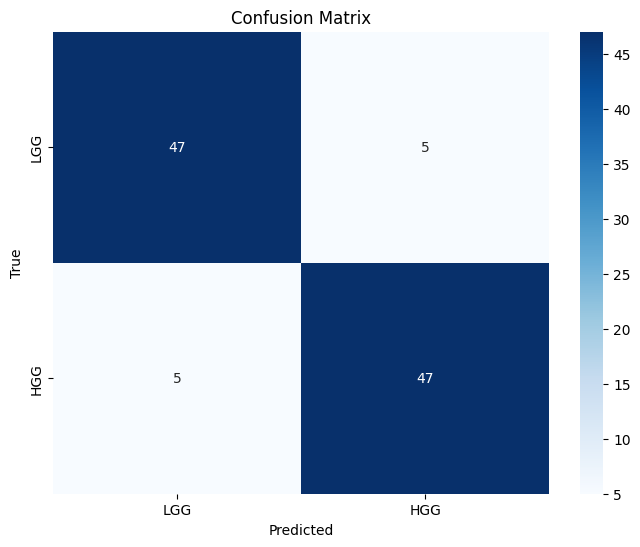

In [ ]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Path to saved model
model_path = '/content/best_model.pth'

# Load model architecture
model = DenseNet121(spatial_dims=2, in_channels=1, out_channels=2)

# Load the saved model state
model.load_state_dict(torch.load(model_path))

# Move the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Set model to evaluation mode
model.eval()

# Initialize lists to store true labels and predictions
all_labels = []
all_predictions = []

# Evaluation loop
with torch.no_grad():
    for batch in val_loader:
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['LGG', 'HGG'], yticklabels=['LGG', 'HGG'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
